# line2line interp, this time with the whole channel minus line 0

# interpolate channel, then interpolate background, then tack together



1. Interpolate background
2. Interpolate channel
3. Make channel boundary
4. Mask out channel for background
4. Mask out background for channel
6. Make into one.

# Skip ahead to load line2line interpolation directly


In [86]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm
import rasterio as rio

from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points

In [87]:
bed_gdf = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp')

In [88]:
def add_distance_to_gdf(gdf):
    """
    Input: geodataframe
    Output: Adds columns 'dx' and 'distance_cum' to the geodataframe
    """
    tmp_dfp = [Point.distance(gdf.geometry.iloc[i]) for i,Point in enumerate(gdf.geometry.iloc[1:])] #note the 1:, equivalent to i+1
    tmp_dfp[:0] = [0]
    gdf['dx'] = pd.Series(tmp_dfp) 
    gdf['distan_cum'] = gdf.dx.cumsum().copy()
    
def add_dDELAYdx(gdf):
    """
    Input: geodataframe
    Output: Adds columns 'dDELAY' and 'dDELAYdx' to the geodataframe
    """
    
    gdf['dDELAY'] = gdf.DELAY.diff().copy()
        
    gdf['dDELAYdx'] = gdf.dDELAY.to_numpy()/gdf.dx.to_numpy()

In [89]:
ll = {} #a dictionary of geodataframes of radarlines over KIS2, ie one gdf for each line.

for line in bed_gdf[bed_gdf.camp =='KIS2'].line_name.unique().tolist():
    ll[line] = bed_gdf[(bed_gdf.line_name==line) & (bed_gdf.camp=='KIS2')].copy()
    ll[line].sort_values(by='x',inplace=True)
    ll[line].reset_index(drop=True,inplace=True)
    add_distance_to_gdf(ll[line])
    add_dDELAYdx(ll[line])
    

In [90]:
bed_gdf[bed_gdf.camp =='KIS2'].line_name.unique()

array(['line7', 'line9', 'line0', 'line10', 'line11', 'line12', 'line13',
       'line14', 'line1', 'line2', 'line3', 'line4', 'line6', 'line7p25',
       'line7p5', 'line7p75', 'line8', 'lineAPREScross', 'lineAPRESdown',
       'lineback2camp', 'linedownchan', 'lineupchan', 'left02',
       'left1011', 'left1213', 'left1415', 'left35', 'left46', 'left79',
       'left810', 'right1112', 'right1314', 'right13', 'right24',
       'right68', 'right910', 'line5'], dtype=object)

In [91]:
cross_channel_lines = [ 'line7p75','line7p5','line7p25','line7', 'line6','line5','lineAPREScross','line4','line3','line2','line1']
add_background_lines = ['line8','left46', 'left79','right68' ]

In [92]:
#lines which cross the channel, (ll restricted to the above subset)
cl  = {key:ll[key] for key in cross_channel_lines}
#background_lines
abl= {key:ll[key] for key in add_background_lines}

### next do channel edges

In [93]:
# find the point at the edge of each channel, where dDELAYdx is over a certain threshold
channel_lmr = {} #left mid right
for key,value in cl.items():
    channel_lmr[key] = [value[abs(value.dDELAYdx) > 20].index[0],
                          value.ice_thickn.idxmin(),
                          value[abs(value.dDELAYdx) > 20].index[-1]] 

In [95]:
#manually adjust
channel_lmr['line7p75'][0]=114
channel_lmr['line7p5'][0]=100
channel_lmr['line7p25'][0]=147
channel_lmr['line7'][0]=566
channel_lmr['line6'][0]=544
channel_lmr['line5'][0]=610
channel_lmr['line5'][2]=813
channel_lmr['lineAPREScross'][0]=415
channel_lmr['lineAPREScross'][2]=650
channel_lmr['line4'][0]=710
# channel_lmr['line3'][0]=635 # too wide?
# channel_lmr['line3'][2]=1062
channel_lmr['line3'][0]=719
channel_lmr['line3'][2]=1062
# channel_lmr['line2'][0]=623 #too wide?
# channel_lmr['line2'][2]=883
channel_lmr['line2'][0]=714
channel_lmr['line2'][2]=883
channel_lmr['line1'][0]=530
channel_lmr['line1'][2]=700
# channel_lmr['line0'][0]=698
# channel_lmr['line0'][2]=885

# 4. Interpolate background

## Drop channel points for the background lines.

In [96]:
background = list(abl.values())

for key,value in cl.items():
    background.append( value.drop(value.index[channel_lmr[key][0]:channel_lmr[key][2]]) )
    
background_df = pd.concat(background)
background_df.reset_index(drop=True,inplace=True)

In [97]:
background_df.keys()

Index(['CDP', 'x', 'y', 'DELAY', 'line_name', 'surf', 'SEQnum', 'camp',
       'time_UTC', 'ice_thickn', 'bed', 'geometry', 'dx', 'distan_cum',
       'dDELAY', 'dDELAYdx'],
      dtype='object')

In [98]:
bed_gdf.keys()

Index(['CDP', 'x', 'y', 'DELAY', 'line_name', 'surf', 'SEQnum', 'camp',
       'time_UTC', 'ice_thickn', 'bed', 'geometry'],
      dtype='object')

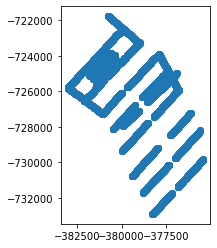

In [99]:
background_df.plot()

In [100]:
b_min = background_df.ice_thickn.min()
b_max = background_df.ice_thickn.max()

### interpolate it

In [101]:
new = pd.DataFrame({})

extent = [background_df.x.min(),background_df.x.max(),background_df.y.min(),background_df.y.max()]

x = np.linspace(extent[0],extent[1], 100)
y = np.linspace(extent[3],extent[2], 100)
xv, yv = np.meshgrid(x ,y ) 

In [102]:
extent

[-383037.7, -375396.8, -732901.4, -721770.2]

In [103]:
out = sp.interpolate.griddata(background_df.loc[:,['x','y']],background_df.ice_thickn,(xv, yv),method='nearest')

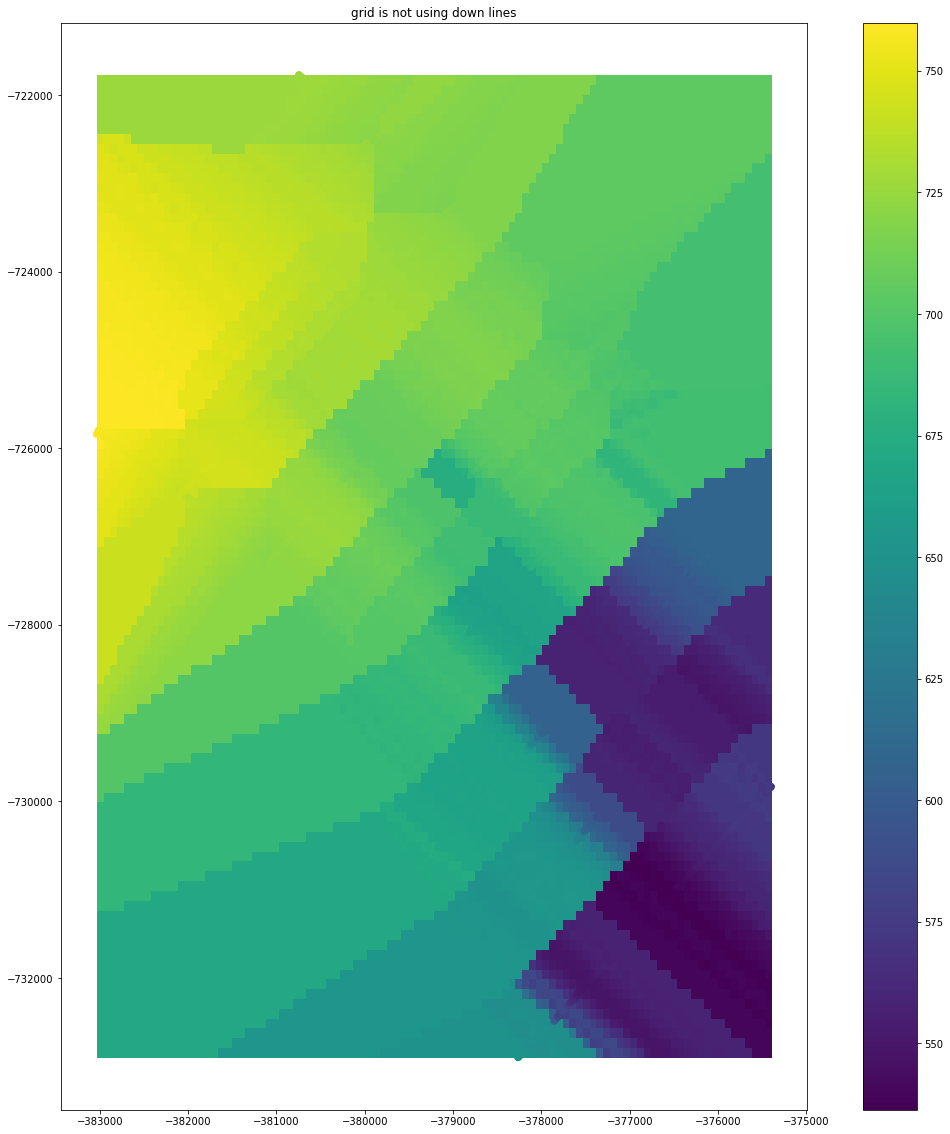

In [104]:
plt.figure(figsize=(20,20))

v = [out.min(),out.max()]
plt.imshow(out,extent=extent,vmin=b_min,vmax=b_max)
plt.scatter(background_df.x,background_df.y,c=background_df.ice_thickn,vmin=b_min,vmax=b_max)
plt.colorbar()
plt.title('grid is not using down lines')

plt.show()

In [105]:
# df = background_df.iloc[::20].copy()
df = background_df.sort_values(by=['y','x']).iloc[::20].copy()
x = np.linspace(df.x.min(),df.x.max(), 1000)
y = np.linspace(df.y.min(),df.y.max(), 1000)

In [106]:
fn = sp.interpolate.SmoothBivariateSpline(df.y,df.x,df.ice_thickn)
out =fn.__call__(y,x)

/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:1065: UserWarning: ier=1481
  warnings.warn(message)


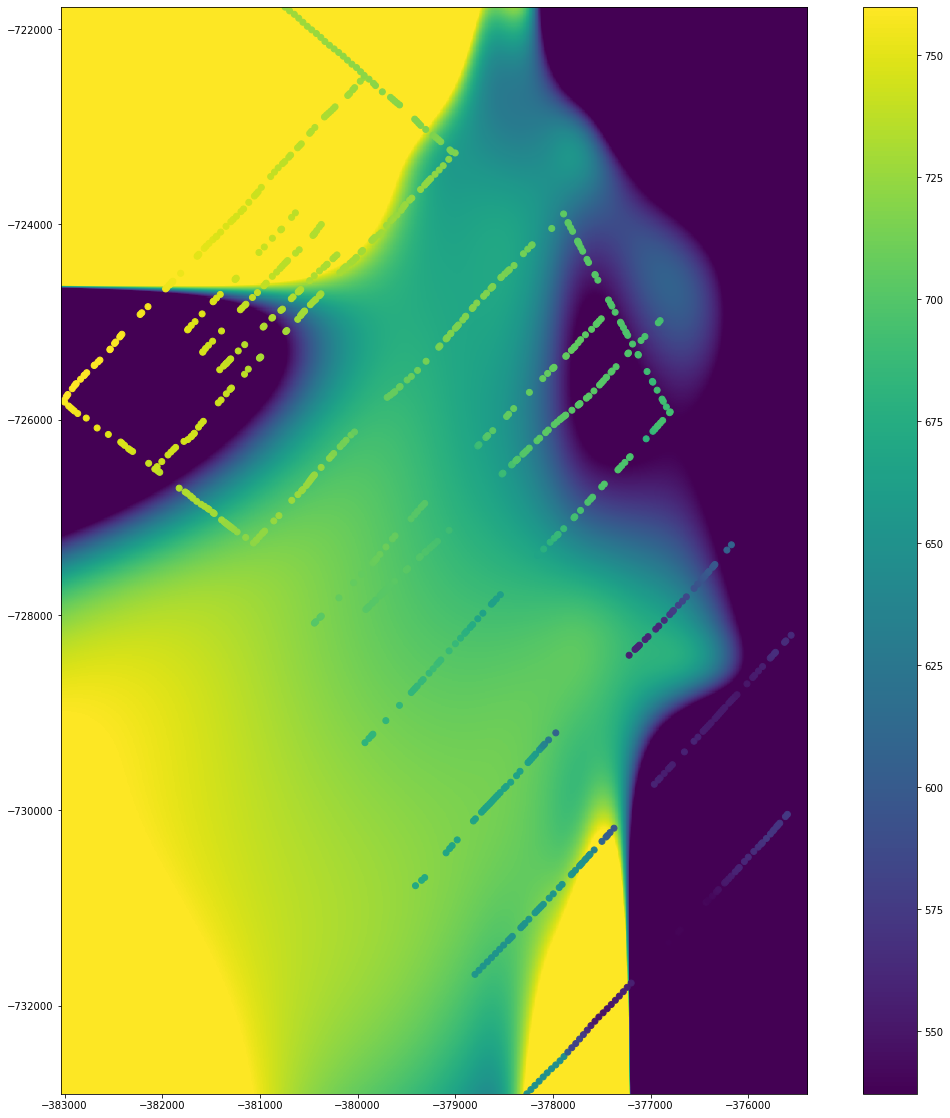

In [107]:
plt.figure(figsize=(20,20))
plt.scatter(df.x,df.y,c=df.ice_thickn,vmin=df.ice_thickn.min(),vmax=df.ice_thickn.max())
plt.imshow(out,extent=extent,vmin=df.ice_thickn.min(),vmax=df.ice_thickn.max())
plt.colorbar()
plt.show()

### Forget the spline interpolation, its quite bad


### Just use 'nearest' but with higher res

In [108]:
new = pd.DataFrame({})

extent = [background_df.x.min(),background_df.x.max(),background_df.y.min(),background_df.y.max()]

x = np.linspace(round(extent[0]),round(extent[1]), 100)
y = np.linspace(round(extent[3]),round(extent[2]), 100)
xv, yv = np.meshgrid(x ,y ) 

In [109]:
out = sp.interpolate.griddata(background_df.loc[::20,['x','y']],background_df.loc[::20].ice_thickn,(xv, yv),method='linear')

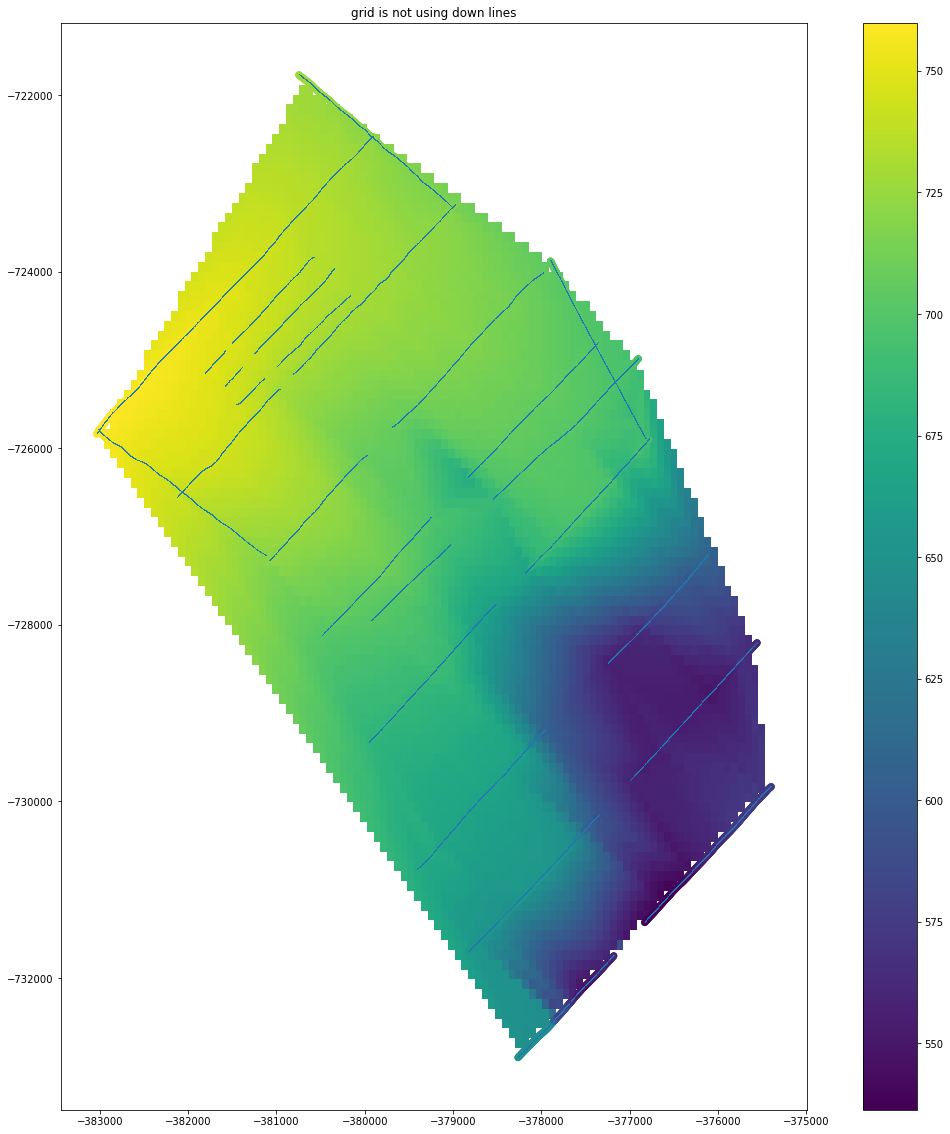

In [110]:
plt.figure(figsize=(20,20))

v = [out.min(),out.max()]
plt.imshow(out,extent=extent,vmin=b_min,vmax=b_max)
plt.scatter(background_df.x,background_df.y,c=background_df.ice_thickn,vmin=b_min,vmax=b_max)
plt.plot(background_df.x,background_df.y,',')
plt.colorbar()
plt.title('grid is not using down lines')

plt.show()

In [111]:
#background interpolated

background_ied = pd.DataFrame({'x':xv.flatten(),'y': yv.flatten(),'ice_thickn': out.flatten()}).sort_values(by=['x','y'])

In [112]:
points = [Point(xy) for xy in zip(background_ied.x,background_ied.y)]
background_gdf = gpd.GeoDataFrame(background_ied,geometry=points,crs="EPSG:3031")

In [113]:
folder = '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/'
background_gdf.to_file(folder+'background_nochannel_all_interp_points.shp')

# this above looks pretty good.

## The channel is already interpolated, dont reinterpolate

### Load the channel interpolation

In [114]:
points_x_chan = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_all_interp_points_x.npy')
points_y_chan = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_all_interp_points_y.npy')
ice_thickn_chan = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_all_interp_ice_thickn.npy')

In [115]:
chan_df = pd.DataFrame({'x': points_x_chan.flatten(),'y': points_y_chan.flatten(),'ice_thickn': ice_thickn_chan.flatten()}).sort_values(by=['x','y'])
points = [Point(xy) for xy in zip(chan_df.x,chan_df.y)]
chan_gdf = gpd.GeoDataFrame(chan_df,geometry=points,crs="EPSG:3031")

In [116]:
c_min = chan_df.ice_thickn.min()
c_max = chan_df.ice_thickn.max()

In [117]:
chan_border_x = points_x_chan[:,0].tolist()+points_x_chan[0,:].tolist()+points_x_chan[:,-1].tolist()+points_x_chan[-1,::-1].tolist()
chan_border_y = points_y_chan[:,0].tolist()+points_y_chan[0,:].tolist()+points_y_chan[:,-1].tolist()+points_y_chan[-1,::-1].tolist()
chan_border_ice_thickn = ice_thickn_chan[:,0].tolist()+ice_thickn_chan[0,:].tolist()+ice_thickn_chan[:,-1].tolist()+ice_thickn_chan[-1,::-1].tolist()

In [118]:
chan_area = Polygon([ (x,y) for x,y in zip(chan_border_x,chan_border_y) ])

In [119]:
background_cut_chan = background_gdf[~background_gdf.geometry.intersects(chan_area)]

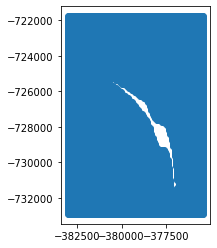

In [120]:
background_cut_chan.plot()

# yea it cuts

In [121]:
background_and_chan_gdf = pd.concat([background_cut_chan ,chan_gdf ])

In [122]:
background_and_chan_gdf.to_file(folder+'line2line_all_interp_points.shp')

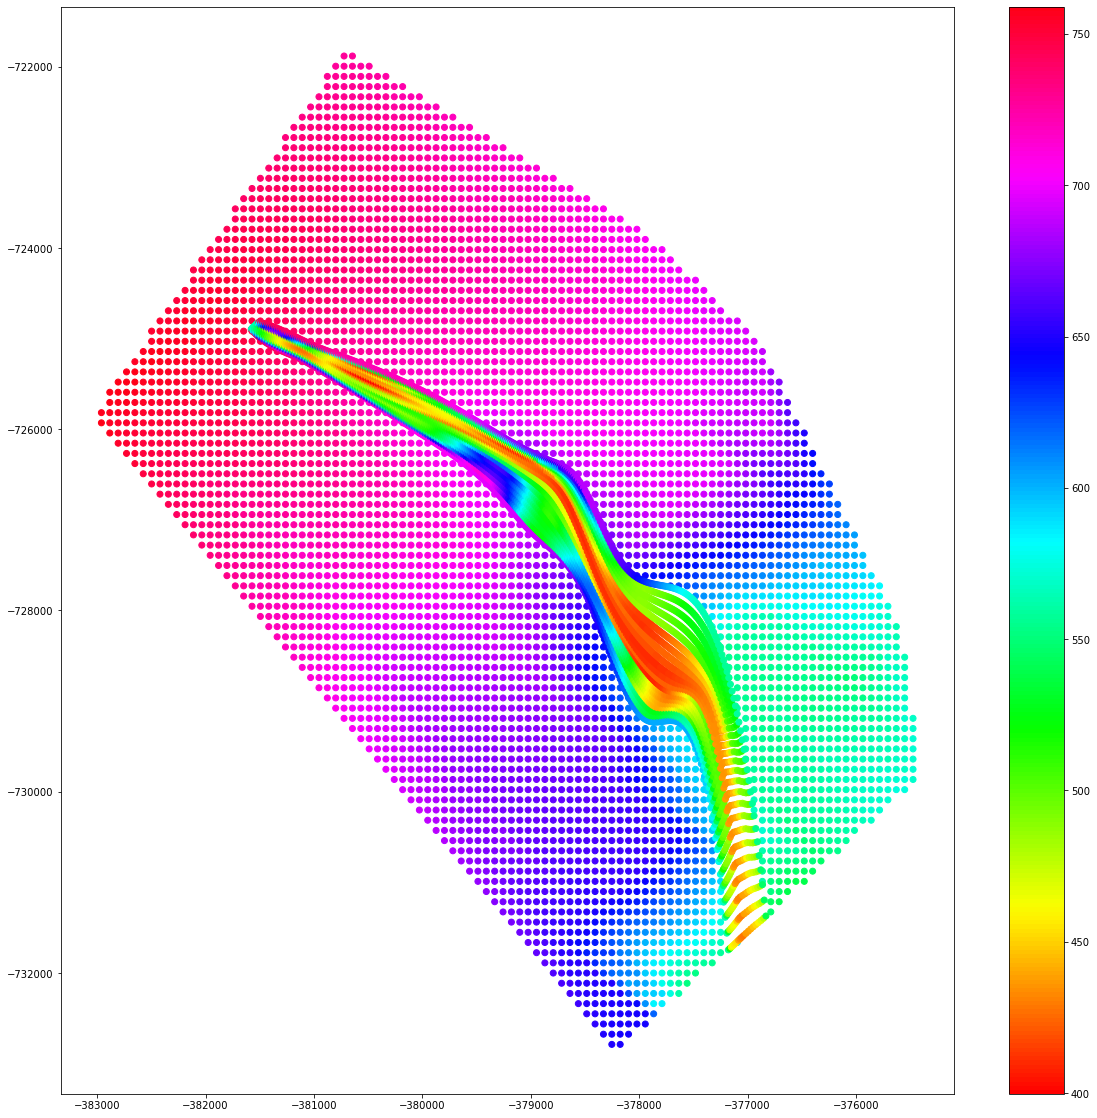

In [123]:
plt.figure(figsize=(20,20))
plt.scatter(background_and_chan_gdf.x,background_and_chan_gdf.y,c=background_and_chan_gdf.ice_thickn,vmin=c_min,vmax=background_and_chan_gdf.ice_thickn.max(),cmap='hsv')
plt.colorbar()
plt.show()

# Interpolate thickness

In [124]:
extent = [background_df.x.min(),background_df.x.max(),background_df.y.min(),background_df.y.max()]

# x = np.linspace(extent[0],extent[1], 200)
# y = np.linspace(extent[3],extent[2], 200)
x = np.arange(round(extent[0]),round(extent[1]), 40)
y = np.flipud(np.arange(round(extent[2]),round(extent[3]), 40))

xv, yv = np.meshgrid(x ,y ) 
thickness_interpolated = sp.interpolate.griddata(background_and_chan_gdf.loc[:,['x','y']],background_and_chan_gdf.ice_thickn,(xv, yv),method='nearest')

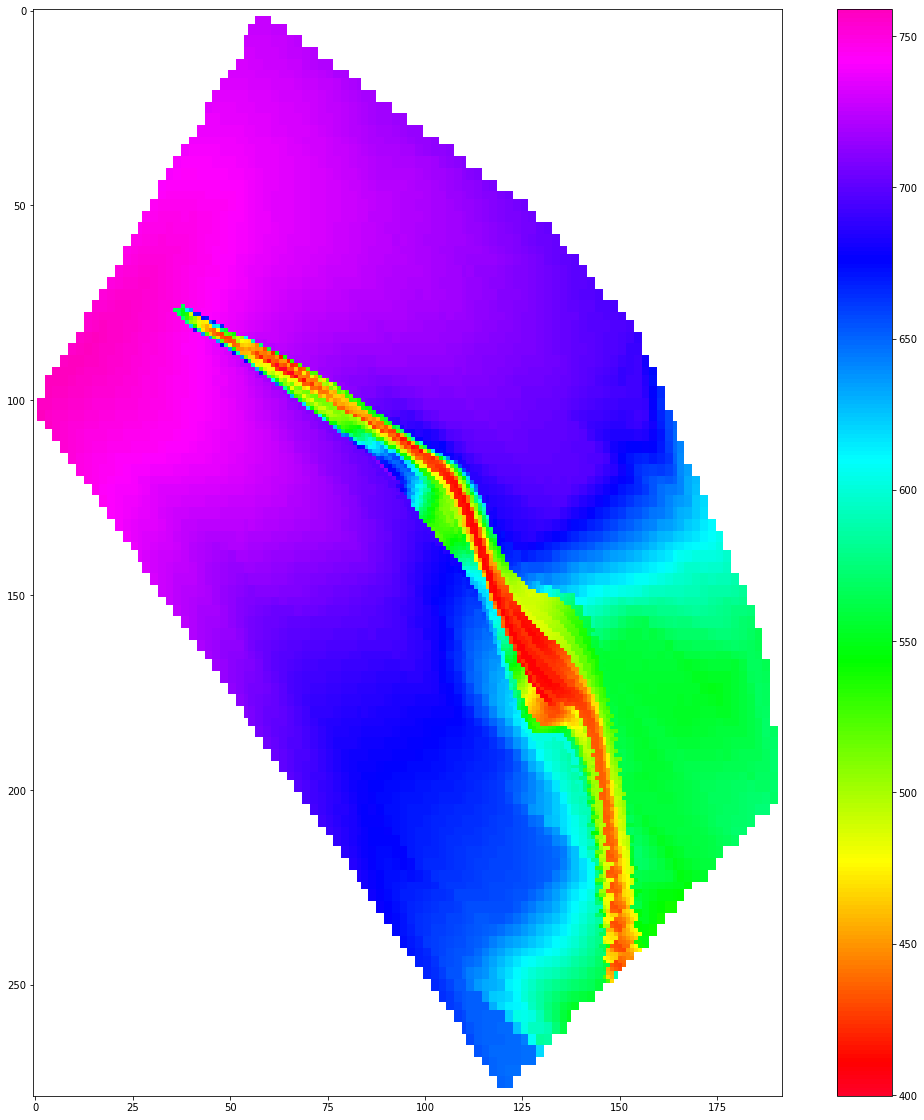

In [125]:
plt.figure(figsize=(20,20))
plt.imshow(thickness_interpolated,cmap='gist_rainbow')
plt.colorbar()
plt.show()

# Contour it

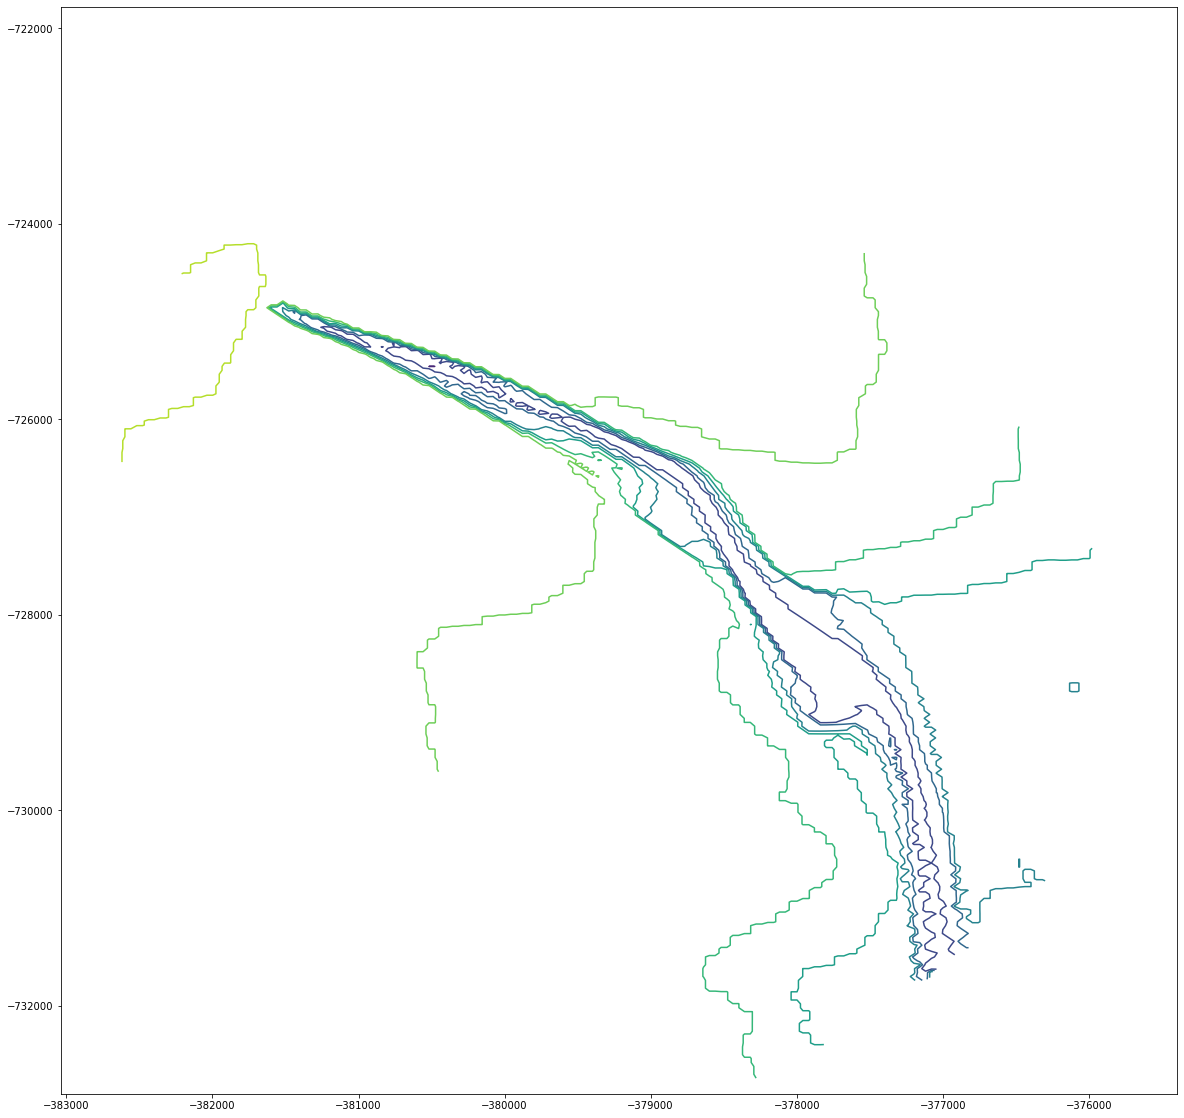

In [126]:
plt.figure(figsize=(20,20))
plt.contour(xv,yv,thickness_interpolated)
plt.show()

# Now repeat with surface

In [127]:
new = pd.DataFrame({})

# extent = [background_df.x.min(),background_df.x.max(),background_df.y.min(),background_df.y.max()]

# # x = np.linspace(round(extent[0]),round(extent[1]), 200)
# # y = np.linspace(round(extent[3]),round(extent[2]), 200)
# x = np.arange(round(extent[0]),round(extent[1]), 40)
# y = np.flipud(np.arange(round(extent[2]),round(extent[3]), 40))



# xv, yv = np.meshgrid(x ,y ) 

bs_min = background_df.surf.min()
bs_max = background_df.surf.max()

In [128]:
to_interp_surf = background_df.drop(background_df.loc[6950:6958].index)

In [129]:
surf_out = sp.interpolate.griddata(to_interp_surf.loc[::20,['x','y']],to_interp_surf.loc[::20].surf,(xv, yv),method='linear')

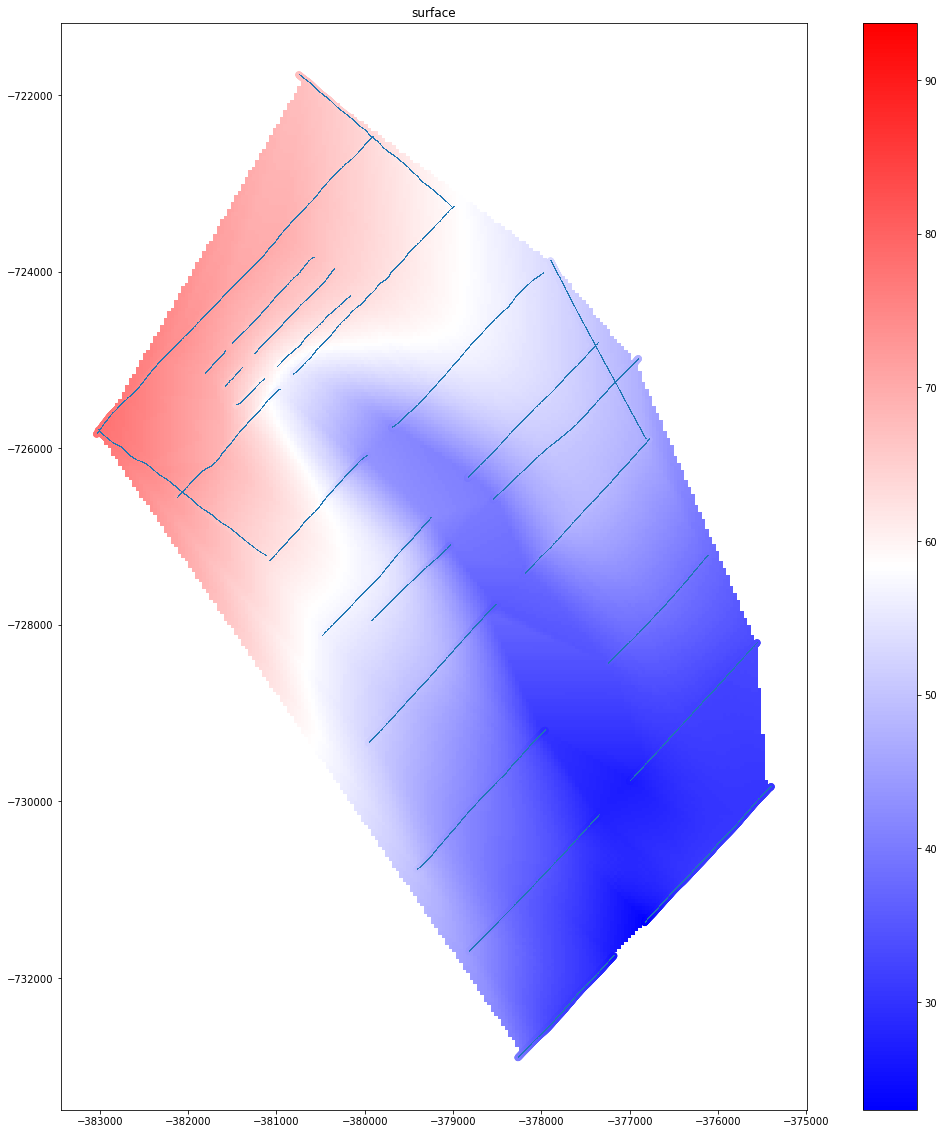

In [130]:
#scatter plots the same color as the interpolation to check its good

plt.figure(figsize=(20,20))

v = [out.min(),out.max()]
plt.imshow(surf_out,extent=extent,vmin=bs_min,vmax=bs_max,cmap='bwr')
plt.scatter(to_interp_surf.x,to_interp_surf.y,c=to_interp_surf.surf,vmin=bs_min,vmax=bs_max,cmap='bwr')
plt.plot(to_interp_surf.x,to_interp_surf.y,',')
plt.colorbar()
plt.title('surface')

plt.show()

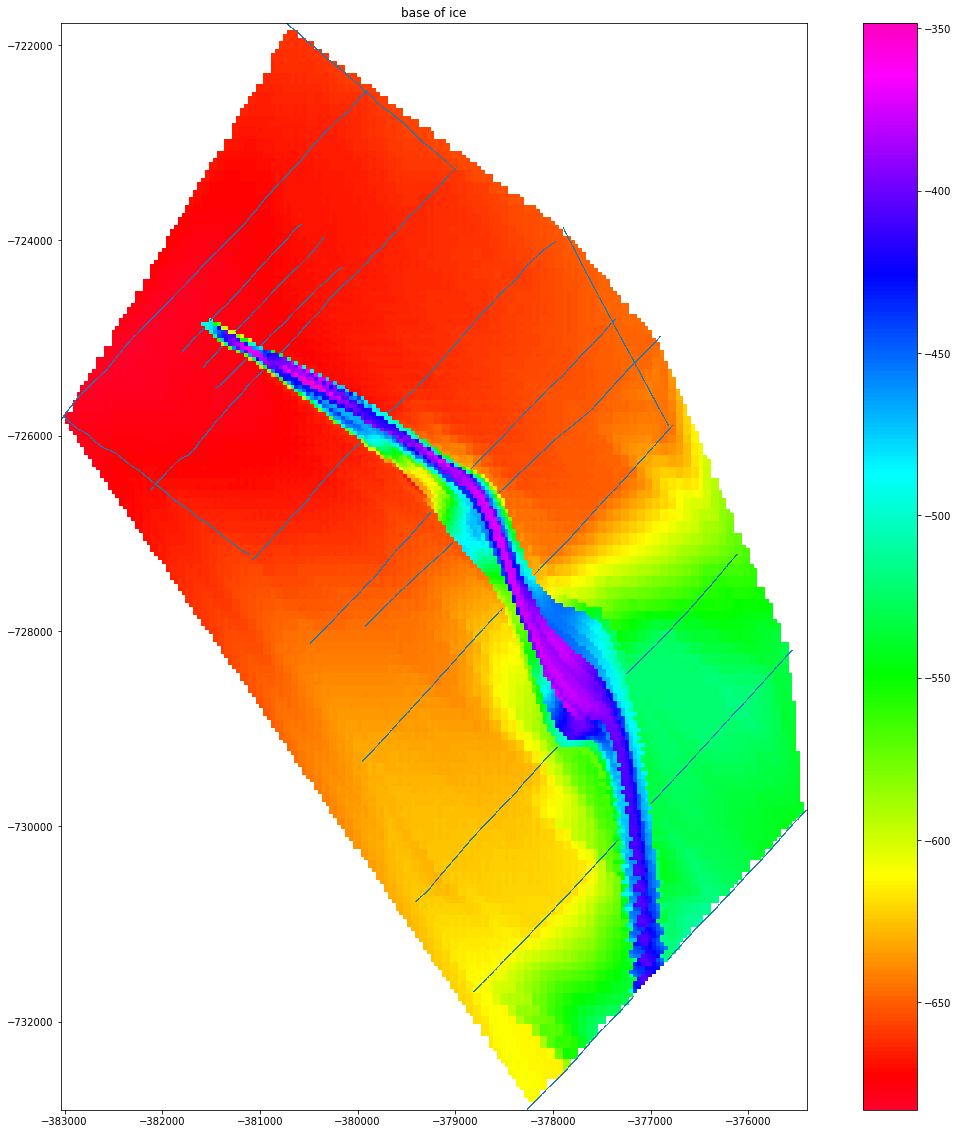

In [131]:
plt.figure(figsize=(20,20))

v = [out.min(),out.max()]
plt.imshow(surf_out-thickness_interpolated,extent=extent,cmap='gist_rainbow')
# plt.scatter(to_interp_surf.x,to_interp_surf.y,c=to_interp_surf.surf)
plt.plot(to_interp_surf.x,to_interp_surf.y,',')
plt.colorbar()
plt.title('base of ice')


plt.show()

# So we have interpolated the surf and thickness now save em

In [132]:
direc = '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/interpolatedgrid_allchan'

np.save(direc + 'x_grid' +'.npy',xv)
np.save(direc + 'y_grid' +'.npy',yv)
np.save(direc +'ice_thickness'+'.npy',thickness_interpolated)
np.save(direc +'extent.npy',np.array(extent))
np.save(direc +'surface.npy',surf_out)

# Write to tiff

https://gis.stackexchange.com/questions/329434/creating-an-in-memory-rasterio-dataset-from-numpy-array/329439#329439

In [133]:
direc = '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/interpolatedgrid_allchan'

xv = np.load(direc + 'x_grid' +'.npy')
yv = np.load(direc + 'y_grid' +'.npy')
thickness_interpolated = np.load(direc +'ice_thickness'+'.npy')
extent = np.load(direc +'extent.npy')
surf_out = np.load(direc +'surface.npy')

In [134]:
# x_scale = -(xmin-xmax)/x_length  # this should be pixel size
x_scale = -(xv[0,0]-xv[0,-1])/xv.shape[1]    
y_scale = -(yv[0,0]-yv[-1,0])/yv.shape[0]   

# x_scale = 40
# y_scale = 40

out_meta = {'driver': 'GTiff',
            'dtype': 'float64',
             'nodata': np.nan,
             'width': thickness_interpolated.shape[1],
             'height': thickness_interpolated.shape[0],
             'count': 1,
             'crs': rio.crs.CRS.from_dict(init='epsg:3031'),
             'transform': rio.Affine(x_scale, 0.0, xv[0,0],0.0, y_scale, yv[0,0])}

In [135]:
print(out_meta)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': nan, 'width': 192, 'height': 279, 'count': 1, 'crs': CRS.from_dict(init='epsg:3031'), 'transform': Affine(39.791666666666664, 0.0, -383038.0,
       0.0, -39.85663082437276, -721781.0)}


In [138]:
#write the cropped tiff of ICE THICKNESS to file
with rio.open("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/thickness_line2line.tif", "w", **out_meta) as dest:
    dest.write(thickness_interpolated.reshape(1,thickness_interpolated.shape[0],thickness_interpolated.shape[1])   )

In [139]:
#write the cropped tiff of SURFACE ELEVATION to file
with rio.open("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/surface_line2line.tif", "w", **out_meta) as dest:
    dest.write(surf_out.reshape(1,surf_out.shape[0],surf_out.shape[1])   )

# Appendix, figuring out how to write a tiff

In [ ]:
with rio.open('/Users/home/whitefar/DATA/REMOTE_SENSING/MODIS-MOA/moa_mediumlarge_field_area.tif') as image:
    extent_moa = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    im_moa = image.read()

In [ ]:
with rio.open('/Users/home/whitefar/DATA/REMOTE_SENSING/MODIS-MOA/moa_mediumlarge_field_area.tif') as src:
    meta_dict = src.meta
    ima_arr = src.read()
meta_dict

In [ ]:
ima_arr.shape

In [ ]:
with rio.open('/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_159202-145074_diff.tif') as src:
    meta_dict = src.meta
meta_dict

In [ ]:
#write the cropped tiff to file
with rio.open(output_filepath + f"REMA{diff_date_str}_{strip1_index}-{strip2_index}dif.tif", "w", **out_meta) as dest:
    dest.write(diff_image)